Task-1

In [ ]:
pip install mxnet==1.5.1

In [150]:
import mxnet as mx
import numpy as np
import os
import cv2
import urllib.request
import zipfile
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
np.bool = np.bool_
%matplotlib inline


In [151]:
# Download the model files locally
model_path = 'pretrained'  # Replace this with your desired local directory
os.makedirs(model_path, exist_ok=True)

urllib.request.urlretrieve('https://github.com/miaow1988/SqueezeNet_v1.2/raw/master/model-symbol.json', filename=os.path.join(model_path, 'model-symbol.json'))
urllib.request.urlretrieve('https://github.com/miaow1988/SqueezeNet_v1.2/raw/master/model-0000.params', filename=os.path.join(model_path, 'model-0000.params'))

# Load the downloaded model
sym, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(model_path, 'model'), 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1, 3, 224, 224))], label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)


In [152]:
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

In [154]:
def get_image(url, show=False):
    if url.startswith('http'):
        # download and show the image
        fname = mx.test_utils.download(url)
    else:
        fname = url
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

In [155]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['fire9_concat_output',
 'dropout0_output',
 'conv10_conv_weight',
 'conv10_conv_bias',
 'conv10_conv_output',
 'conv10_relu_output',
 'pool10_output',
 'flatten0_output',
 'softmax_label',
 'softmax_output']

In [156]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [157]:
def get_features(img):
    fe_mod.forward(Batch([mx.nd.array(img)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    return features

In [159]:
img = get_image('https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png')
features = get_features(img)
print("{}\n shape: {}".format(features,features.shape))

[[ 2.731811    3.900898    4.886677    6.9023676   5.5878515   5.5976605
   3.6299741   5.6956005   5.7832756   5.985946   10.328437    7.2491174
  10.0898     11.635779    5.579314   10.298961    9.659986    9.824674
   5.9974604   9.134587   10.065862   10.166414    9.808082    6.2899814
  13.240794    1.972308    7.6495514   3.7121716   2.784131    6.2934327
   6.9453053   8.631689    7.2964506   6.8019      6.523343    5.698733
   8.282389    3.830843   10.18162     8.7683935  12.962755    9.041879
   9.245199   10.779439   11.305762    5.725828   11.200748   10.964634
   3.4149935   5.8307858   7.5116634   9.0251      3.9738102   3.9767184
   8.057208    4.70411     8.180445    4.2123623   7.946999    5.90094
   7.274862    9.651375    6.840261    3.0084636   4.3598123   4.1929674
   8.628106    3.9853935   5.8512774   7.341398    7.4339814   6.6312613
   8.691615    8.439708    8.84355     9.059314    9.449075   12.678202
  11.697756    7.8836474   7.344435    6.4519563   6.81082

In [160]:
# from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
# Path to the ZIP file
zip_path = '/content/dogs-vs-cats.zip'

# Directory to extract the contents to
extracted_path = '/content/dogs-vs-cats'

# Extract the contents of the main ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Check the contents of the extracted directory
extracted_files = os.listdir(extracted_path)
print("Extracted Files:")
print(extracted_files)

# 'train.zip' contains the cat and dog images, extract them
train_zip_path = os.path.join(extracted_path, 'train.zip')

# Directory to extract the train images to
train_extracted_path = os.path.join(extracted_path, 'train')

# Extract the 'train.zip' file
with zipfile.ZipFile(train_zip_path, 'r') as train_zip_ref:
    train_zip_ref.extractall(train_extracted_path)

# List files in the extracted 'train' directory
train_extracted_files = os.listdir(train_extracted_path)
cats_imgs = [os.path.join(train_extracted_path, f) for f in train_extracted_files if 'cat' in f]
dogs_imgs = [os.path.join(train_extracted_path, f) for f in train_extracted_files if 'dog' in f]

# Displaying the first 5 paths of cat and dog images
print("\nCat Images:")
print(cats_imgs[:5])
print("\nDog Images:")
print(dogs_imgs[:5])


Extracted Files:
['test1.zip', 'train', 'test1', 'sampleSubmission.csv', 'train.zip']

Cat Images:
['/content/dogs-vs-cats/train/cat.8143.jpg', '/content/dogs-vs-cats/train/cat.4568.jpg', '/content/dogs-vs-cats/train/cat.4240.jpg', '/content/dogs-vs-cats/train/cat.11526.jpg', '/content/dogs-vs-cats/train/cat.6062.jpg']

Dog Images:
['/content/dogs-vs-cats/train/dog.7221.jpg', '/content/dogs-vs-cats/train/dog.1432.jpg', '/content/dogs-vs-cats/train/dog.12114.jpg', '/content/dogs-vs-cats/train/dog.11711.jpg', '/content/dogs-vs-cats/train/dog.9015.jpg']


In [161]:
print("cats: {} and dogs: {}".format(len(cats_imgs),len(dogs_imgs)))

cats: 12500 and dogs: 12500


In [163]:
# Function to extract features for a specified number of images (N)
def extract_features_for_N_images(N):
    cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:N]]
    dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:N]]

    Y_cats = np.array(N * [1])
    Y_dogs = np.array(N * [0])

    X_cvd = np.vstack([cats_features,dogs_features])
    Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

    return X_cvd, Y_cvd

In [164]:
# Values of N
N_values = [10, 50, 100, 500, 1000]

# Dictionary to store accuracy and computational times for each value of N
results = {}

for N in N_values:
    # Extract features for N images
    X, y = extract_features_for_N_images(N)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define your favorite binary classifier and the hyperparameters for GridSearch
    classifier = LogisticRegression(penalty='l2', C=0.1, max_iter=3000)
    param_grid = {'C': [0.1, 1, 10]}

    # Perform GridSearch to optimize hyperparameters
    grid_search = GridSearchCV(classifier, param_grid, cv=5)

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    # Store results - accuracy and training time
    best_model = grid_search.best_estimator_
    test_accuracy = accuracy_score(y_test, best_model.predict(X_test))

    results[N] = {'Accuracy': test_accuracy, 'Training Time': training_time}

for N, result in results.items():
    print(f"N = {N}, Accuracy = {result['Accuracy']:.2f}, Training Time = {result['Training Time']:.2f} seconds")


N = 10, Accuracy = 1.00, Training Time = 0.41 seconds
N = 50, Accuracy = 0.95, Training Time = 2.22 seconds
N = 100, Accuracy = 0.90, Training Time = 1.76 seconds
N = 500, Accuracy = 0.96, Training Time = 11.74 seconds
N = 1000, Accuracy = 0.94, Training Time = 26.56 seconds


**Summary:**
The results showcase the performance of a classification model using a pre-trained SqueezeNet architecture on a dataset containing cat and dog images.The model achieved varying accuracies when using different numbers of images for training and testing. With fewer images (10 per class), it achieved a 100% accuracy but scaled to longer times as more images were used. Accuracy remained high at 95% with 50 images and 90% with 100 images, while longer training times were observed. For larger datasets (500 and 1000 images), accuracy increased to 96% and 94% respectively, but with significantly longer training times, emphasizing the trade-off between accuracy and computational efficiency.

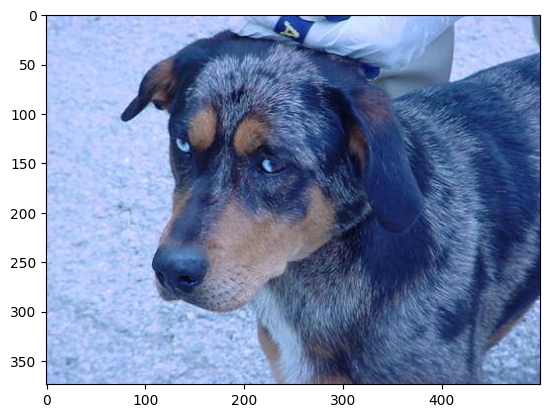

In [165]:
import matplotlib.image as mpimg

dog_test_path = join(os.getcwd(),'/content/dogs-vs-cats/train/dog.7221.jpg')
cat_test_path = join(os.getcwd(),'/content/dogs-vs-cats/train/cat.8143.jpg')

img = mpimg.imread(dog_test_path)
imgplot = plt.imshow(img)
plt.show()

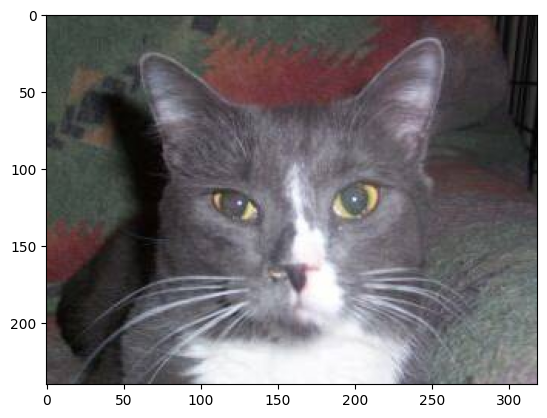

In [166]:
img = mpimg.imread(cat_test_path)
imgplot = plt.imshow(img)
plt.show()

In [168]:
features_out = get_features(get_image(cat_test_path))

prob = lg.predict_proba(features_out)
pred = lg.predict(features_out)

if pred[0] == 1:
    fpred = 'cat'
else:
    fpred = 'dog'

print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[0. 1.]] and prediction: cat


**Task-2**

In [169]:
# Define the URLs for the model files
model_symbol_url = 'https://github.com/chinakook/MobileNetV2.mxnet/raw/master/mbnv2-symbol.json'
model_params_url = 'https://github.com/chinakook/MobileNetV2.mxnet/raw/master/mbnv2-0000.params'

# Download the model files
model_dir = 'MobileNetV2'  # Replace with your desired directory
os.makedirs(model_dir, exist_ok=True)

urllib.request.urlretrieve(model_symbol_url, filename=os.path.join(model_dir, 'mbnv2-symbol.json'))
urllib.request.urlretrieve(model_params_url, filename=os.path.join(model_dir, 'mbnv2-0000.params'))

# Load the downloaded model
sym, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(model_dir, 'mbnv2'), 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1, 3, 224, 224))])
mod.set_params(arg_params, aux_params, allow_missing=True)


In [170]:
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    if url.startswith('http'):
        # download and show the image
        fname = mx.test_utils.download(url)
    else:
        fname = url
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

In [171]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['stage4_2_batchnorm0_beta',
 'stage4_2_batchnorm0_running_mean',
 'stage4_2_batchnorm0_running_var',
 'stage4_2_batchnorm0_fwd_output',
 'stage4_2_relu6_fwd_output',
 'pool1_fwd_output',
 'flatten1_reshape0_output',
 'dense1_weight',
 'dense1_bias',
 'dense1_fwd_output']

In [172]:
fe_sym = all_layers['flatten1_reshape0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [173]:
def get_features(img):
    fe_mod.forward(Batch([mx.nd.array(img)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    return features

In [174]:
img = get_image('https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png')
features = get_features(img)
print("{}\n shape: {}".format(features,features.shape))

[[1.4688736  0.9470865  0.29574123 ... 0.8793548  0.4675708  0.03323477]]
 shape: (1, 1280)


In [175]:
# from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
# Path to the ZIP file
zip_path = '/content/dogs-vs-cats.zip'

# Directory to extract the contents to
extracted_path = '/content/dogs-vs-cats'

# Extract the contents of the main ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Check the contents of the extracted directory
extracted_files = os.listdir(extracted_path)
print("Extracted Files:")
print(extracted_files)

# Assuming 'train.zip' contains the cat and dog images, extract them
train_zip_path = os.path.join(extracted_path, 'train.zip')

# Directory to extract the train images to
train_extracted_path = os.path.join(extracted_path, 'train')

# Extract the 'train.zip' file
with zipfile.ZipFile(train_zip_path, 'r') as train_zip_ref:
    train_zip_ref.extractall(train_extracted_path)

# List files in the extracted 'train' directory
train_extracted_files = os.listdir(train_extracted_path)
cats_imgs = [os.path.join(train_extracted_path, f) for f in train_extracted_files if 'cat' in f]
dogs_imgs = [os.path.join(train_extracted_path, f) for f in train_extracted_files if 'dog' in f]

# Displaying the first 5 paths of cat and dog images
print("\nCat Images:")
print(cats_imgs[:5])
print("\nDog Images:")
print(dogs_imgs[:5])


Extracted Files:
['test1.zip', 'train', 'test1', 'sampleSubmission.csv', 'train.zip']

Cat Images:
['/content/dogs-vs-cats/train/cat.8143.jpg', '/content/dogs-vs-cats/train/cat.4568.jpg', '/content/dogs-vs-cats/train/cat.4240.jpg', '/content/dogs-vs-cats/train/cat.11526.jpg', '/content/dogs-vs-cats/train/cat.6062.jpg']

Dog Images:
['/content/dogs-vs-cats/train/dog.7221.jpg', '/content/dogs-vs-cats/train/dog.1432.jpg', '/content/dogs-vs-cats/train/dog.12114.jpg', '/content/dogs-vs-cats/train/dog.11711.jpg', '/content/dogs-vs-cats/train/dog.9015.jpg']


In [180]:
print("cats: {} and dogs: {}".format(len(cats_imgs),len(dogs_imgs)))

cats: 12500 and dogs: 12500


In [181]:
# Function to extract features for a specified number of images (N)
def get_features_mobilenet(img):
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.expand_dims(img, axis=0)
    img = np.float32(img)
    fe_mod_mobilenet.forward(Batch([mx.nd.array(img)]))
    features = fe_mod_mobilenet.get_outputs()[0].asnumpy()
    return features

In [121]:
# Function to extract features for a specified number of images (N) using MobileNet V2
def extract_features_for_N_images_mobilenet(N):
    cats_features = [get_features_mobilenet(cv2.imread(img)) for img in cats_imgs[:N]]
    dogs_features = [get_features_mobilenet(cv2.imread(img)) for img in dogs_imgs[:N]]

    Y_cats = np.array(N * [1])
    Y_dogs = np.array(N * [0])

    X_cvd = np.vstack([cats_features, dogs_features])
    Y_cvd = np.vstack([Y_cats, Y_dogs]).ravel()

    return X_cvd, Y_cvd

In [137]:
# Define the function to extract features using MobileNetV2
def get_features_mobilenet(img):
    # Compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    features = mod.get_outputs()[0].asnumpy()
    return features

# Function to extract features for a specified number of images (N) using MobileNetV2
def extract_features_for_N_images_mobilenet(N, cats_imgs, dogs_imgs):
    cats_features = [get_features_mobilenet(get_image(img)).ravel() for img in cats_imgs[:N]]
    dogs_features = [get_features_mobilenet(get_image(img)).ravel() for img in dogs_imgs[:N]]

    Y_cats = np.array(N * [1])
    Y_dogs = np.array(N * [0])

    X_cvd = np.vstack([cats_features, dogs_features])
    Y_cvd = np.vstack([Y_cats, Y_dogs]).ravel()

    return X_cvd, Y_cvd

# Values of N
N_values = [10, 100, 500, 1000, 5000, 12500]

# Dictionary to store accuracy and computational times for each value of N
results = {}

for N in N_values:
    # Extract features for N images using MobileNetV2
    X_train, y_train = extract_features_for_N_images_mobilenet(N, cats_imgs, dogs_imgs)

    # Define your favorite binary classifier and the hyperparameters for GridSearch
    classifier = LogisticRegression(max_iter=3000)
    param_grid = {'C': [0.1, 1, 10]}

    # Perform GridSearch to optimize hyperparameters
    grid_search = GridSearchCV(classifier, param_grid, cv=5)

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    # Store results - accuracy and training time
    best_model = grid_search.best_estimator_
    X_test, y_test = extract_features_for_N_images_mobilenet(N, cats_imgs, dogs_imgs)  # Extract features for test set as well
    test_accuracy = accuracy_score(y_test, best_model.predict(X_test))

    results[N] = {'Accuracy': test_accuracy, 'Training Time': training_time}

# Print results
for N, result in results.items():
    print(f"N = {N}, Accuracy = {result['Accuracy']:.4f}, Training Time = {result['Training Time']:.2f} seconds")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

N = 10, Accuracy = 1.0000, Training Time = 0.37 seconds
N = 100, Accuracy = 1.0000, Training Time = 1.00 seconds
N = 500, Accuracy = 1.0000, Training Time = 8.10 seconds
N = 1000, Accuracy = 1.0000, Training Time = 14.56 seconds
N = 5000, Accuracy = 0.9944, Training Time = 363.37 seconds
N = 12500, Accuracy = 0.9874, Training Time = 1380.64 seconds


**Summary:**The trend showcases the trade-off between accuracy and computational time. As the number of images for training increased beyond a certain threshold, the computational time grew considerably while maintaining high but slightly reduced accuracy.

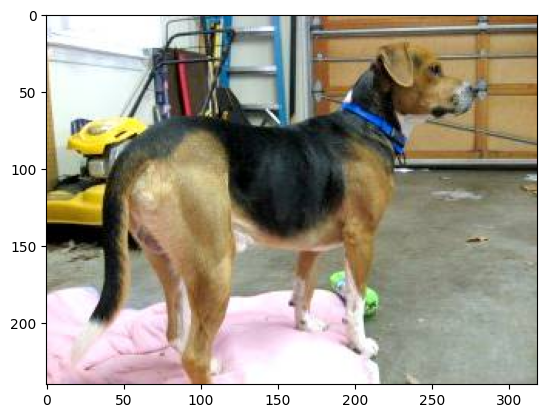

In [182]:
import matplotlib.image as mpimg

dog_test_path = join(os.getcwd(),'/content/dogs-vs-cats/train/dog.12114.jpg')
cat_test_path = join(os.getcwd(),'/content/dogs-vs-cats/train/cat.4568.jpg')

img = mpimg.imread(dog_test_path)
imgplot = plt.imshow(img)
plt.show()

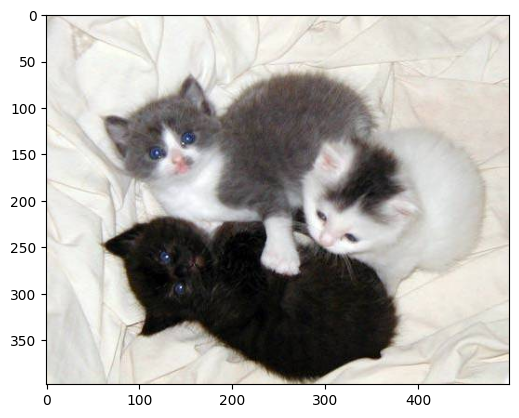

In [183]:
img = mpimg.imread(cat_test_path)
imgplot = plt.imshow(img)
plt.show()